**Table of Contents**

1. [Introduction](#introduction)
   - [Setup](#setup)
2. [Data Exploring](#data-exploring)
   - [Data Loading](#data-loading)
   - [Data Preparation](#data-preparation)
      - [Are there any countries lost in the cleaning process?](#are-there-any-countries-lost-in-the-cleaning-process)
3. [General Analysis - 2000-2022](#general-analysis---2000-2022)
   - [Top 10 Countries with higher and lower Tariffs](#top-10-countries-with-higher-and-lower-tariffs)
      - [Outlier Analysis](#outlier-analysis)
   - [Average Tariffs by Country on a Map](#average-tariffs-by-country-on-a-map)
   - [Tariff Statistics by Wealth Level](#tariff-statistics-by-wealth-level)
      - [Visualizing the Differences Between Wealth Levels](#visualizing-the-differences-between-quartiles)
      - [Average Tariffs Rate by Wealth Level](#average-tariffs-rate-by-wealth-level)
      - [Time Series Comparison Between Wealth Levels](#time-series-comparison-between-wealth-groups)
    - [Volatility Analysis](#volatility-analysis)
4. [In-depth Analysis](#in-depth-analysis)
   - [Correlation Analysis](#correlation-analysis)
   - [Regression Analysis](#regression-analysis)
   - [Hypothesis Testing](#hypothesis-testing)
   - [Trade Openness Analysis](#trade-openness-analysis)
5. [Final Considerations](#final-considerations)

# Introduction

In an increasingly interconnected global economy, tariffs remain a crucial instrument of trade policy. Defined as taxes imposed on imported goods, tariffs serve multiple purposes: they generate government revenue, protect domestic industries from foreign competition and can be used as tools of economic diplomacy. However, tariff policies vary dramatically across countries, raising questions about what drives these differences.

This analysis investigates a central question in international trade economics: *do richer countries impose lower tariffs than poorer countries?* Understanding this relationship is essential for comprehending global trade patterns, economic development strategies and the underlying logic of protectionism versus free trade.

Using data from the [World Bank's World Integrated Trade Solution (WITS)](https://wits.worldbank.org/Default.aspx?lang=en) database, we examine tariff rates across countries from 2000 to 2022, exploring how national wealth - measured by GDP - correlates with tariff policy.

The following analysis proceeds in four main stages. First, we load and prepare the data, merging them into a unified dataset. Second, we conduct exploratory analysis to understand the overall landscape of global tariff policy and identify key patterns. Third, we apply formal statistical methods - correlation analysis, regression modeling and hypothesis testing - to rigorously test our central hypothesis. Finally, we synthesize our findings and  discuss their implications for international trade policy and economic development.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import plotly.express as px
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_style("whitegrid") # set whitegrid theme for the plotsthat use the seaborn package
plt.rcParams["figure.figsize"] = (12, 7) # default sizes for Maplotlib graphs

In [2]:
def heading(phrase):
    """helper function to print section headings"""
    print("\n" + "=" * 60)
    print(phrase)
    print("=" * 60 + "\n")

# Data exploring

### Data loading

Before diving into analysis, we need to load and prepare our data. We will be working with three main datasets from the World Bank's WITS database:

1. **Tariff Data**: applied tariff rates by country and year;
2. **GDP Data**: national economic output in USD;
3. **Trade Data**: trade volume as percentage of GDP (a measure of economic openness).

Our goal is to merge these datasets into a unified structure that allows us to examine relationships between wealth, trade policy and economic openness.

In [3]:
heading("LOADING DATA")

base_url = "https://raw.githubusercontent.com/Elisa-PSC/CPDM_project_20252026/main/data"

# Load complete datasets (all years)
df_tariffs_all = pd.read_csv(base_url + "/WITS-Product_bycountry_all.csv")
df_gdp_all = pd.read_csv(base_url + "/WITS-Country-GDP_USD_all.csv")
df_trade_all = pd.read_csv(base_url + "/WITS-Trade_percentage_of_GDP_all.csv")

print(f"Complete tariff data: {df_tariffs_all.shape[0]} rows, {df_tariffs_all.shape[1]} columns")
print(f"Complete GDP data: {df_gdp_all.shape[0]} rows, {df_gdp_all.shape[1]} columns")
print(f"Complete trade data: {df_trade_all.shape[0]} rows, {df_trade_all.shape[1]} columns")


LOADING DATA

Complete tariff data: 189 rows, 40 columns
Complete GDP data: 190 rows, 37 columns
Complete trade data: 175 rows, 37 columns


### Data preparation

Our datasets are in "wide" format (years as columns), but we need "long" format (years as rows) for easier analysis and visualization.

To achieve that, we will:

1. reshape all three datasets from wide to long format;
2. merge them into a single comprehensive dataset;
3. handle missing values appropriately;
4. create derived variables (log-transformed GDP, wealth quartiles).

In [4]:
heading("PREPARING DATA")

# Reshape tariff data from wide to long format, i.e. from columns to rows
tariff_historical = df_tariffs_all.melt(
    id_vars=["Reporter Name", "Partner Name", "Trade Flow", "Product Group", "Indicator"],
    value_vars=[str(year) for year in range(1988, 2023)],
    var_name="Year",
    value_name="Tariff_Rate",
)
tariff_historical["Year"] = tariff_historical["Year"].astype(int)

# Reshape GDP data
gdp_historical = df_gdp_all.melt(
    id_vars=["Country Name", "Indicator Name"],
    value_vars=[str(year) for year in range(1988, 2023)],
    var_name="Year",
    value_name="GDP_USD",
)
gdp_historical["Year"] = gdp_historical["Year"].astype(int)

# Reshape trade data
trade_historical = df_trade_all.melt(
    id_vars=["Country Name", "Indicator Name"],
    value_vars=[str(year) for year in range(1988, 2023)],
    var_name="Year",
    value_name="Trade_Pct_GDP",
)
trade_historical["Year"] = trade_historical["Year"].astype(int)

# Merge all datasets
merged_all = tariff_historical.merge(
    gdp_historical[["Country Name", "Year", "GDP_USD"]],
    left_on=["Reporter Name", "Year"],
    right_on=["Country Name", "Year"],
    how="left",
)
merged_all = merged_all.merge(
    trade_historical[["Country Name", "Year", "Trade_Pct_GDP"]],
    left_on=["Reporter Name", "Year"],
    right_on=["Country Name", "Year"],
    how="left",
    suffixes=("", "_trade"),
)
merged_all = merged_all.drop(columns=["Country Name", "Country Name_trade"])

countries_before = set(merged_all["Reporter Name"].unique())

# Cleaning
merged_all = merged_all.dropna(subset=["GDP_USD", "Tariff_Rate"])

countries_after = set(merged_all["Reporter Name"].unique())

print(f"\nComplete merged dataset (1988-2022): {merged_all.shape[0]} observations")
print(f"Number of countries: {merged_all['Reporter Name'].nunique()}")
print(f"Years covered: {sorted(merged_all['Year'].unique().tolist())}")

# Preparing the log(GDP) for later use
merged_all["GDP_Log"] = np.log10(merged_all["GDP_USD"])



PREPARING DATA


Complete merged dataset (1988-2022): 3589 observations
Number of countries: 179
Years covered: [1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [5]:
countries_per_year = merged_all.groupby("Year")["Reporter Name"].nunique()
print(countries_per_year.head(13))

Year
1988      3
1989      8
1990      8
1991     10
1992     13
1993     23
1994     13
1995     38
1996     59
1997     63
1998     63
1999     76
2000    109
Name: Reporter Name, dtype: int64


Although the full dataset spans 1988–2022, the main analysis focuses on the period 2000–2022 due to data quality considerations. In the earlier years, country coverage is extremely limited, with fewer than 25 countries observed throughout most of the 1990s and as few as three countries in the late 1980s. This sparse and uneven coverage raises concerns about representativeness, sampling bias, and the reliability of summary statistics derived from such small samples.

Restricting the analysis to 2000–2022 ensures consistently large and diverse samples (typically exceeding 100 countries per year) allowing for stable estimates and meaningful statistical inference. This period still provides substantial temporal depth to examine long-run patterns and responses to global economic shocks, while maintaining rigorous standards of data reliability and comparability.

In [6]:
# Filtering years from 2000 to 2022
merged = merged_all[merged_all["Year"].between(2000, 2022)].copy()

# Create wealth quartiles based on the filtered dataset
labels = ["Poorest 25%", "Lower-Middle 25%", "Upper-Middle 25%", "Richest 25%"]
merged["Wealth_Quartile"] = pd.qcut(merged["GDP_USD"], q=4, labels=labels, duplicates='drop')

print(f"\nFiltered dataset (2000-2022): {merged.shape[0]} observations")
print(f"Number of countries: {merged['Reporter Name'].nunique()}")
print(f"Years covered: {sorted(merged['Year'].unique().tolist())}")


Filtered dataset (2000-2022): 3212 observations
Number of countries: 177
Years covered: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


#### Are there any countries lost in the cleaning process?

In [7]:
lost_countries = countries_before - countries_after
print(f"Countries before cleaning: {len(countries_before)}")
print(f"Countries after cleaning: {len(countries_after)}")
print(f"Countries lost entirely: {len(lost_countries)}")
print(sorted(lost_countries))

Countries before cleaning: 189
Countries after cleaning: 179
Countries lost entirely: 10
['Congo, Dem. Rep.', 'Cook Islands', 'East Timor', 'European Union', 'Mayotte', 'Montenegro', 'Montserrat', 'Romania', 'Serbia, FR(Serbia/Montenegro)', 'Sudan']


# General Analysis - 2000-2022

Now that our data is prepared, we will begin with broad exploratory analysis to  understand the overall landscape of global tariff policy.

Key questions we will aim to answer:

- What is the average tariff rate globally?
- How much variation exists between countries?
- Are tariff rates stable over time or do they fluctuate?
- Which countries represent the extremes of trade policy?

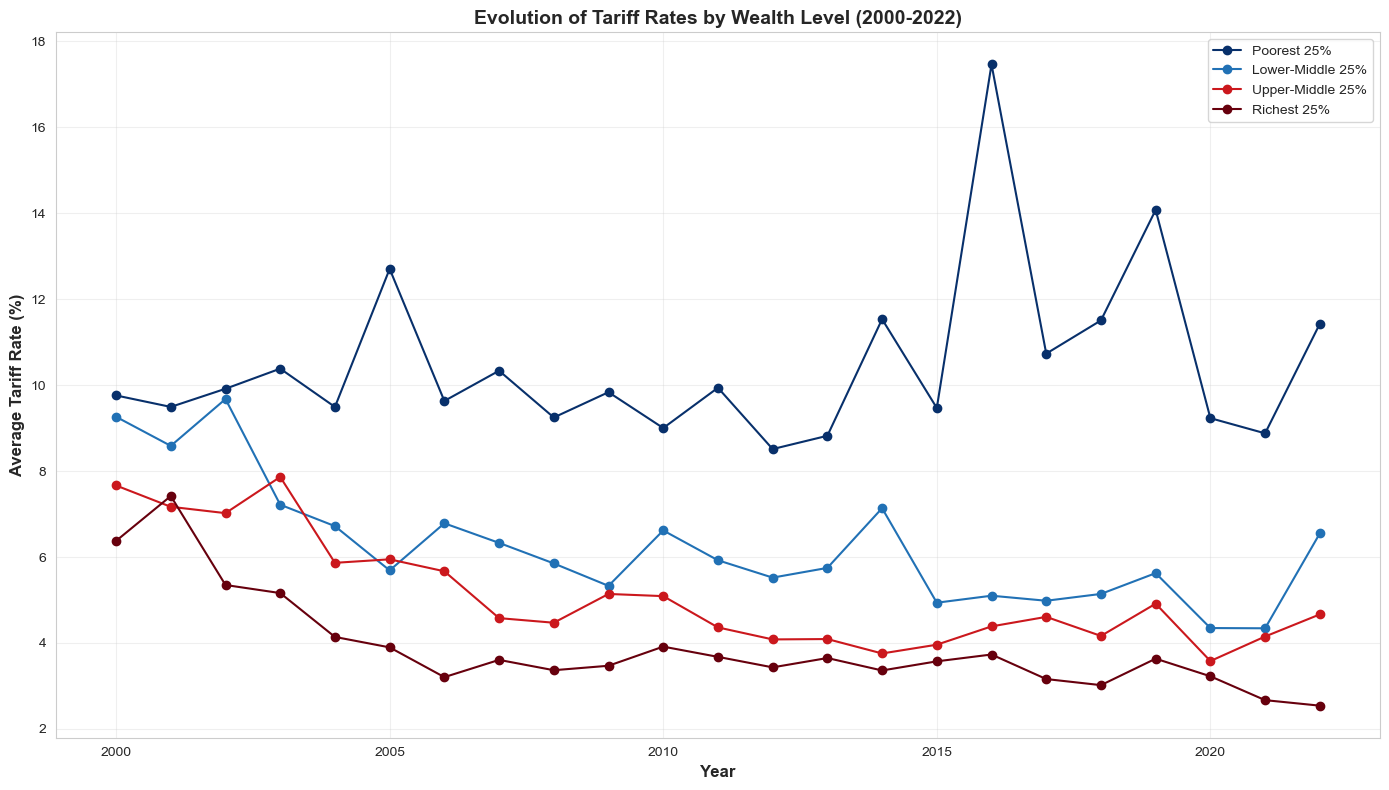

In [8]:
# Wealth group trends over time
wealth_trends = merged.groupby(["Year", "Wealth_Quartile"], observed=True).agg({
    "Tariff_Rate": "mean"
}).reset_index()

colors = ["#08306b", "#2171b5", "#cb181d", "#67000d"]

plt.figure(figsize=(14, 8))
for quartile, color in zip(labels, colors):
    data = wealth_trends[wealth_trends["Wealth_Quartile"] == quartile]
    plt.plot(
        data["Year"],
        data["Tariff_Rate"],
        marker='o',
        label=quartile,
        linewidth=1.5,
        color=color
    )

plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Average Tariff Rate (%)", fontsize=12, fontweight="bold")
plt.title("Evolution of Tariff Rates by Wealth Level (2000-2022)", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("fig_evolution_by_wealth.png", dpi=300, bbox_inches="tight")
plt.show()

## Top 10 Countries with higher and lower tariffs

### Outlier analysis

By examining the countries with the highest and lowest tariff rates, we can see dramatically different approaches to trade policy.

This contrast raises several important questions: which economic or political forces tend to accompany strong protectionist policies; whether countries with very low tariffs share common traits; and how wide the divide truly is between the world’s most open and most restrictive economies.

This analysis helps us understand not just the average relationship, but the full range of policy choices countries make.

In [9]:
heading("OUTLIER ANALYSIS")

# Calculate z-scores
merged["Tariff_ZScore"] = stats.zscore(merged["Tariff_Rate"])

# Find outliers (|z| > 2)
outliers = merged[np.abs(merged["Tariff_ZScore"]) > 2].copy()
outliers = outliers.sort_values("Tariff_ZScore", ascending=False)

print(f"\nIdentified {len(outliers)} outlier observations (|z-score| > 2):")
print(
    outliers[
        ["Reporter Name", "Year", "Tariff_Rate", "Wealth_Quartile", "Tariff_ZScore"]
    ].head(10)
)

# Count outliers by country
outlier_countries = outliers["Reporter Name"].value_counts().head(10)
print("\nCountries with Most Outlier Years:")
print(outlier_countries)

# # To create a well-formatted markdown table for the presentation
# top_outliers = outliers[
#     ["Reporter Name", "Year", "Tariff_Rate", "Wealth_Quartile", "Tariff_ZScore"]
# ].head(
#     10
# )

# top_outliers = top_outliers.copy()
# top_outliers["Tariff_Rate"] = top_outliers["Tariff_Rate"].round(2).astype(str) + "%"
# top_outliers["Tariff_ZScore"] = top_outliers["Tariff_ZScore"].round(4)

# outlier_countries = outliers["Reporter Name"].value_counts().head(10)
# outlier_countries = outlier_countries.to_frame(name="Count")

# print(top_outliers.to_markdown(index=False))
# print(outlier_countries.to_markdown())


OUTLIER ANALYSIS


Identified 47 outlier observations (|z-score| > 2):
        Reporter Name  Year  Tariff_Rate   Wealth_Quartile  Tariff_ZScore
5331          Comoros  2016   274.072795       Poorest 25%      35.601648
5878          Bermuda  2019   103.171485       Poorest 25%      12.880843
4975             Fiji  2014    91.593897       Poorest 25%      11.341639
5101           Zambia  2014    77.866747  Lower-Middle 25%       9.516656
3274             Fiji  2005    65.891565       Poorest 25%       7.924593
6613           Zambia  2022    42.842771  Lower-Middle 25%       4.860326
5258  Solomon Islands  2015    35.649655       Poorest 25%       3.904024
5803            Palau  2018    34.629877       Poorest 25%       3.768447
3363       Seychelles  2005    32.601668       Poorest 25%       3.498803
3552       Seychelles  2006    32.581581       Poorest 25%       3.496133

Countries with Most Outlier Years:
Reporter Name
India                       5
Seychelles                  5
Berm

## Average tariffs by Country on a map

In [10]:
# Filter for the most recent year available in your dataset
latest_year = merged["Year"].max()
df_map = merged[merged["Year"] == latest_year].copy()

# Round the values for cleaner display
df_map["Tariff_Rate"] = df_map["Tariff_Rate"].round(2)
df_map["GDP_USD"] = df_map["GDP_USD"].round(0)
df_map["Trade_Pct_GDP"] = df_map["Trade_Pct_GDP"].round(2)

custom_colors = [
    [0.0, "#08306b"],
    [0.33, "#2171b5"],
    [0.67, "#cb181d"],
    [1.0, "#67000d"],
]

# Create the Choropleth Map with formatted hover data
fig_map = px.choropleth(
    df_map,
    locations="Reporter Name",
    locationmode="country names",
    color="Tariff_Rate",
    hover_name="Reporter Name",
    hover_data={
        "Reporter Name": False,
        "Tariff_Rate": ":.2f",
        "GDP_USD": ":,.0f",
        "Trade_Pct_GDP": ":.2f",
    },
    color_continuous_scale=custom_colors,
    title=f"Global Distribution of Applied Tariff Rates ({latest_year})",
    labels={
        "Tariff_Rate": "Tariff Rate (%)",
        "GDP_USD": "GDP (USD)",
        "Trade_Pct_GDP": "Trade (% of GDP)",
    },
)

fig_map.update_layout(
    geo=dict(showframe=False, showcoastlines=True, projection_type="equirectangular"),
    margin={"r": 0, "t": 50, "l": 0, "b": 0},
    dragmode=False,
)

# fig_map.show()

/var/folders/0b/2vd461rd2f16n42_yjx2h3b80000gn/T/ipykernel_68954/2220600816.py:18: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig_map = px.choropleth(


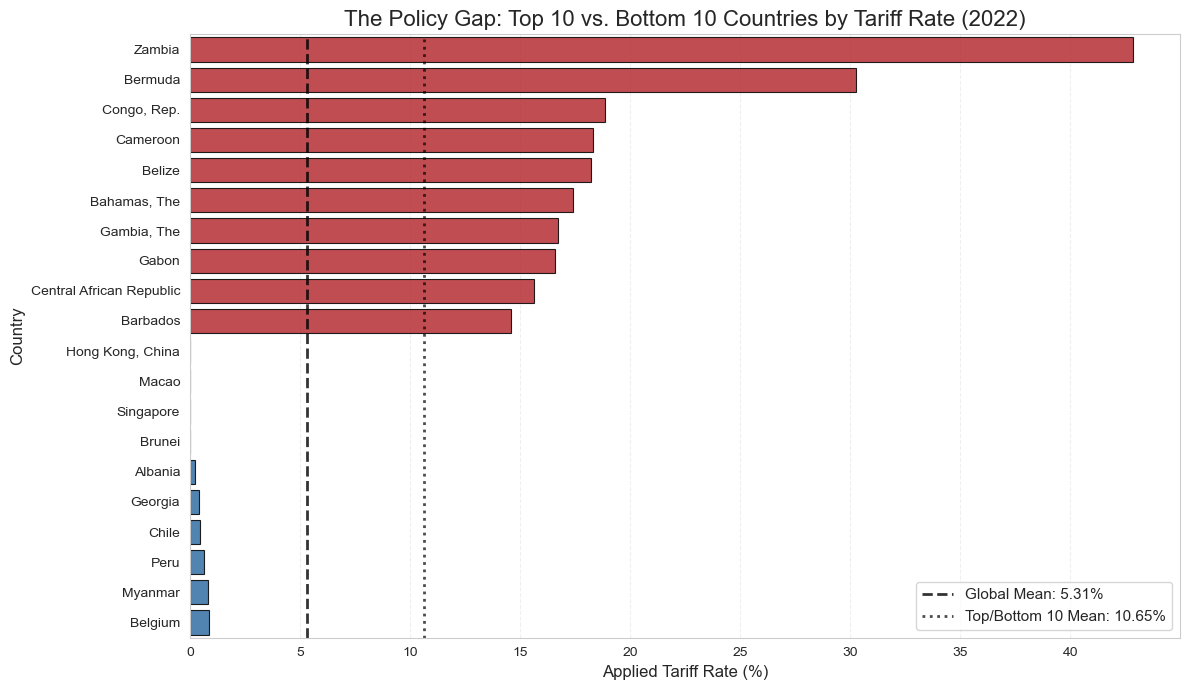

In [11]:
# Get the most recent data
df_recent = merged[merged["Year"] == latest_year]

# Identify the extremes
top_10 = df_recent.nlargest(10, "Tariff_Rate")
bottom_10 = df_recent.nsmallest(10, "Tariff_Rate")
extremes = pd.concat([top_10, bottom_10])

plt.figure(figsize=(12, 7))
# Colors: red for Top 10, blue for Bottom 10
colors = ["#cb181d"] * 10 + [
    "#2171b5",
] * 10

global_mean = df_recent["Tariff_Rate"].mean()
extremes_mean = extremes["Tariff_Rate"].mean()

sns.barplot(
    data=extremes,
    x="Tariff_Rate",
    y="Reporter Name",
    palette=colors,
    alpha=0.85,
    linewidth=0.8,
    edgecolor="black",
    legend=False,
)

plt.axvline(
    x=global_mean,
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"Global Mean: {global_mean:.2f}%",
    alpha=0.8,
)

plt.axvline(
    x=extremes_mean,
    color="black",
    linestyle=":",
    linewidth=2,
    label=f"Top/Bottom 10 Mean: {extremes_mean:.2f}%",
    alpha=0.7,
)

plt.title(
    f"The Policy Gap: Top 10 vs. Bottom 10 Countries by Tariff Rate ({latest_year})",
    fontsize=16,
)
plt.xlabel("Applied Tariff Rate (%)", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.legend(loc="lower right", fontsize=11, frameon=True, fancybox=True)
plt.grid(axis="x", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.savefig("fig_top_10_bottom_.png", dpi=300, bbox_inches="tight")
plt.show()

The latter figure highlights a pronounced policy gap between countries with the highest and lowest applied tariff rates in 2022. The top ten countries exhibit tariff levels that are not only substantially higher than the global average of 5.23%, but also clustered well above it, with several countries exceeding 15% and one reaching above 40%. In contrast, the bottom ten countries apply tariffs that are close to zero, indicating near-complete trade openness in practical terms. This stark contrast is reinforced by the mean tariff rate for the top and bottom groups combined (10.65%), which lies far above the global average, underscoring how extreme observations drive much of the dispersion in tariff policy. Overall, the plot reveals that while average global tariffs appear moderate, they conceal deep heterogeneity, with a small group of countries maintaining highly protectionist regimes and another group operating at the opposite extreme.

## Tariff statistics by wealth level

This is where we directly begin to test our central hypothesis: do richer countries have lower tariffs?

By dividing countries into four wealth quartiles (poorest 25%, lower-middle 25%, upper-middle 25%, richest 25%), we can examine whether tariff rates systematically differ across wealth levels.

What we're testing:

- Is there a clear "staircase" pattern where each wealth level has lower tariffs?
- How large is the gap between the poorest and richest countries?
- Is the relationship smooth, or are there thresholds/jumps at certain wealth levels?

In [12]:
heading("TARIFF STATISTICS BY WEALTH LEVEL")

labels = ["Poorest 25%", "Lower-Middle 25%", "Upper-Middle 25%", "Richest 25%"]
merged["Wealth_Quartile"] = pd.qcut(merged["GDP_USD"], q=4, labels=labels, duplicates='drop')

wealth_summary = merged.groupby("Wealth_Quartile", observed=True).agg({
    "Tariff_Rate": ["count", "mean", "median", "std", "min", "max"],
    "GDP_USD": ["mean"]
}).round(2)

print("DETAILED BREAKDOWN BY WEALTH QUARTILE:")
print(wealth_summary)

# Calculate key findings
poorest = merged[merged['Wealth_Quartile'] == 'Poorest 25%']['Tariff_Rate']
richest = merged[merged['Wealth_Quartile'] == 'Richest 25%']['Tariff_Rate']

heading("KEY FINDINGS - THE WEALTH-TARIFF RELATIONSHIP")

print(f"\n1. POOREST 25% OF COUNTRIES:")
print(f"Average tariff: {poorest.mean():.2f}%")
print(f"Median tariff: {poorest.median():.2f}%")
print(f"Range: {poorest.min():.2f}% to {poorest.max():.2f}%")

print(f"\n2. RICHEST 25% OF COUNTRIES:")
print(f"Average tariff: {richest.mean():.2f}%")
print(f"Median tariff: {richest.median():.2f}%")
print(f"Range: {richest.min():.2f}% to {richest.max():.2f}%")

difference = poorest.mean() - richest.mean()
percent_higher = ((poorest.mean() / richest.mean()) - 1) * 100

print(f"\n3. THE GAP:")
print(f"Absolute difference: {difference:.2f} percentage points")
print(f"Relative difference: Poorest countries have {percent_higher:.1f}% HIGHER tariffs")

# # To create a well-formatted markdown table for the presentation
# formatted = wealth_summary.copy()

# tariff_cols = [
#     ("Tariff_Rate", "mean"),
#     ("Tariff_Rate", "median"),
#     ("Tariff_Rate", "std"),
#     ("Tariff_Rate", "min"),
#     ("Tariff_Rate", "max"),
# ]

# for col in tariff_cols:
#     formatted[col] = formatted[col].apply(lambda x: f"{x:.2f}%")

# formatted[("GDP_USD", "mean")] = formatted[("GDP_USD", "mean")].apply(
#     lambda x: f"{x:,.0f}"
# )

# print(formatted.to_markdown())


TARIFF STATISTICS BY WEALTH LEVEL

DETAILED BREAKDOWN BY WEALTH QUARTILE:
                 Tariff_Rate                                         GDP_USD
                       count   mean median    std  min     max          mean
Wealth_Quartile                                                             
Poorest 25%              803  10.40   9.67  11.93  0.0  274.07  4.077350e+09
Lower-Middle 25%         803   6.06   4.96   5.42  0.0   77.87  2.000744e+10
Upper-Middle 25%         803   5.02   3.61   4.40  0.0   25.42  1.121377e+11
Richest 25%              803   3.65   2.39   3.17  0.0   26.51  1.703107e+12

KEY FINDINGS - THE WEALTH-TARIFF RELATIONSHIP


1. POOREST 25% OF COUNTRIES:
Average tariff: 10.40%
Median tariff: 9.67%
Range: 0.00% to 274.07%

2. RICHEST 25% OF COUNTRIES:
Average tariff: 3.65%
Median tariff: 2.39%
Range: 0.00% to 26.51%

3. THE GAP:
Absolute difference: 6.74 percentage points
Relative difference: Poorest countries have 184.5% HIGHER tariffs


The difference between the upper-middle and richest quartiles is relatively modest, suggesting that once countries reach a certain level of development, tariff policies converge toward lower rates.

The maximum tariff values tell a similar story: the two wealthiest quartiles show comparable maximum values, but these increase progressively for lower-middle income  countries and reach extreme levels among the poorest nations - approximately seven times higher than wealthy countries. This pattern strongly suggests that countries maintaining exceptionally high tariffs are predominantly found among the poorest nations.

The standard deviation within each quartile provides additional insight. The poorest group exhibits the highest variability, indicating significant heterogeneity in trade
policy approaches among low-income countries. This suggests that while poverty correlates with higher tariffs on average, it doesn't determine policy - some poor  countries choose relatively open trade policies while others maintain high protection.

Most importantly, the mean difference of 6.74 percentage points between the poorest and richest quartiles - representing a 185% higher tariff rate among poor countries - demonstrates that these groups occupy fundamentally different trade policy regimes.
This substantial gap provides strong preliminary evidence that GDP and tariff policy are indeed meaningfully connected, with wealthier nations consistently maintaining more liberal trade policies than their poorer counterparts.

### Visualizing the differences between quartiles

#### Average tariffs rate by wealth level
</br>

The following chart shows average tariff rates for each wealth quartile, making the relationship  visible at a glance.

A clear descending pattern from left to right would confirm our hypothesis visually.

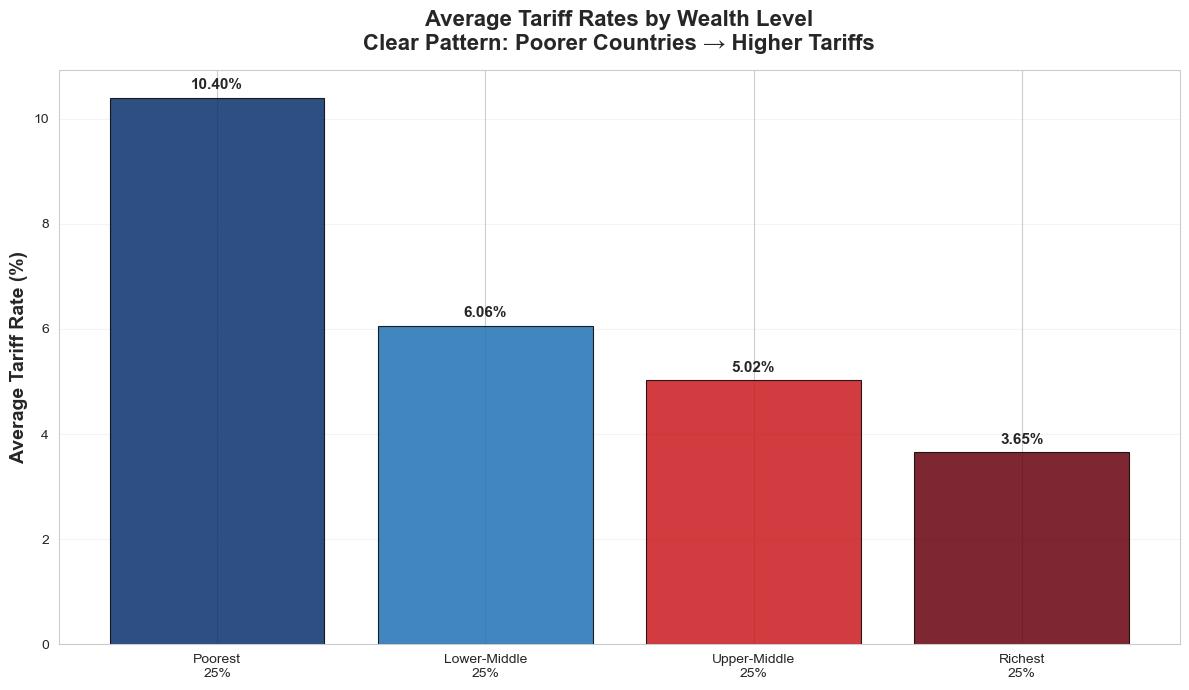

In [13]:
quartiles_order = ["Poorest 25%", "Lower-Middle 25%", "Upper-Middle 25%", "Richest 25%"]
colors = ["#08306b", "#2171b5", "#cb181d", "#67000d"]

stats_all = (
    merged.groupby("Wealth_Quartile", observed=True)["Tariff_Rate"]
    .agg(["mean", "std"])
    .reindex(quartiles_order)
)
mean_tariffs = stats_all["mean"].values
std_tariffs = stats_all["std"].values

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(
    ["Poorest\n25%", "Lower-Middle\n25%", "Upper-Middle\n25%", "Richest\n25%"],
    mean_tariffs,
    # yerr=std_tariffs,
    capsize=10,
    color=colors,
    alpha=0.85,
    edgecolor="black",
    linewidth=0.8,
)

for bar, mean in zip(bars, mean_tariffs):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.1,
        f"{mean:.2f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
        fontsize=11,
    )

ax.set_ylabel("Average Tariff Rate (%)", fontsize=14, fontweight="bold")
ax.set_title(
    "Average Tariff Rates by Wealth Level\nClear Pattern: Poorer Countries → Higher Tariffs",
    fontsize=16,
    fontweight="bold",
    pad=15,
)
ax.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.savefig("fig_wealth_quartile_bars.png", dpi=300, bbox_inches="tight")
plt.show()

#### Time series comparison between wealth groups
</br>

We've established that richer countries have lower tariffs *on average*, but is this a stable relationship? Or might the gap widen or narrow in response to global events?

By tracking the poorest and richest quartiles separately over time, we can assess whether the wealth-tariff gap is growing or shrinking, how each group responds to global economic shocks and whether convergence is happening (poor countries lowering tariffs over time).

Stable patterns across years strengthen our confidence that we're observing a fundamental structural relationship, not a temporary correlation.

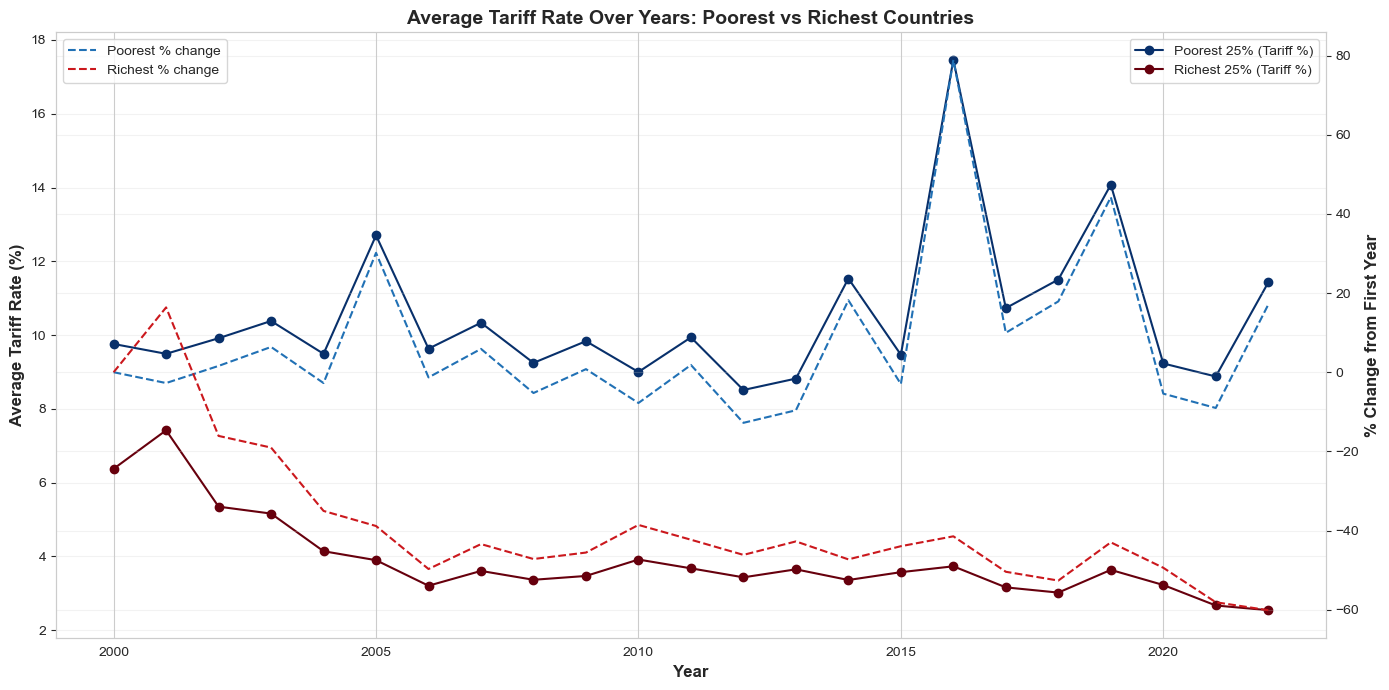

In [14]:
#  average tariff per year for richest and poorest quartiles
yearly_tariffs = (
    merged.groupby(["Year", "Wealth_Quartile"], observed=True)["Tariff_Rate"]
    .mean()
    .reset_index()
)


yearly_tariffs = yearly_tariffs[
    yearly_tariffs["Wealth_Quartile"].isin(["Poorest 25%", "Richest 25%"])
]


pivot_tariffs = yearly_tariffs.pivot(
    index="Year", columns="Wealth_Quartile", values="Tariff_Rate"
)

pivot_tariffs["Poorest % change"] = (
    pivot_tariffs["Poorest 25%"] / pivot_tariffs["Poorest 25%"].iloc[0] - 1
) * 100
pivot_tariffs["Richest % change"] = (
    pivot_tariffs["Richest 25%"] / pivot_tariffs["Richest 25%"].iloc[0] - 1
) * 100

fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(
    pivot_tariffs.index,
    pivot_tariffs["Poorest 25%"],
    marker="o",
    color="#08306b",
    linewidth=1.5,
    label="Poorest 25% (Tariff %)",
)
ax1.plot(
    pivot_tariffs.index,
    pivot_tariffs["Richest 25%"],
    marker="o",
    color="#67000d",
    linewidth=1.5,
    label="Richest 25% (Tariff %)",
)

ax1.set_xlabel("Year", fontsize=12, fontweight="bold")
ax1.set_ylabel("Average Tariff Rate (%)", fontsize=12, fontweight="bold")
ax1.set_title(
    "Average Tariff Rate Over Years: Poorest vs Richest Countries",
    fontsize=14,
    fontweight="bold",
)
ax1.set_axisbelow(True)
ax1.grid(True, axis="y", alpha=0.25, linewidth=0.8)
ax1.legend(loc="upper right", frameon=True)

# Plot percentage changes
ax2 = ax1.twinx()
ax2.plot(
    pivot_tariffs.index,
    pivot_tariffs["Poorest % change"],
    "--",
    color="#2171b5",
    linewidth=1.5,
    label="Poorest % change",
)
ax2.plot(
    pivot_tariffs.index,
    pivot_tariffs["Richest % change"],
    "--",
    color="#cb181d",
    linewidth=1.5,
    label="Richest % change",
)
ax2.set_ylabel("% Change from First Year", fontsize=12, fontweight="bold")
ax2.set_axisbelow(True)
ax2.grid(True, axis="y", alpha=0.25, linewidth=0.8)
ax2.legend(loc="upper left", frameon=True)

plt.tight_layout()
plt.savefig("fig_avg_tariff_years.png", dpi=300, bbox_inches="tight")
plt.show()

The graph shows a persistent and widening divergence in tariff policies between the poorest and richest countries from 2000 to 2022. Throughout the entire period, poorer countries consistently maintain higher average tariff rates than richer countries, with no meaningful convergence over time. While the richest countries steadily reduced tariffs - cutting them by roughly half - poorest countries exhibited high volatility and ended the period at approximately the same tariff level at which they began.

The visualization also highlights asymmetric responses to global shocks. Poorer countries experienced sharp tariff fluctuations, including a pronounced spike around 2016, whereas richer countries followed a smoother and more stable liberalization path. Relative to the 2000 baseline, poorest countries show no net liberalization over 23 years, while richest countries achieved substantial and sustained tariff reductions.

Overall, the figure suggests that trade liberalization has been uneven across income groups. Rather than converging, tariff policies have followed divergent trajectories, with poorer countries remaining locked into higher and more volatile tariff regimes, reinforcing the long-term wealth–tariff gap.

## Volatility Analysis

Some countries maintain remarkably consistent tariff policies year after year, while others frequently adjust rates in response to economic or political pressures.

We will identify which countries have the most and least volatile tariff policies.

In [15]:
heading("TARIFF POLICY VOLATILITY ANALYSIS")

# Calculate standard deviation for each country across years
volatility = (
    merged.groupby("Reporter Name")
    .agg(
        {
            "Tariff_Rate": ["mean", "std", "min", "max"],
            "Wealth_Quartile": lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
        }
    )
    .round(2)
)

volatility.columns = ["Mean_Tariff", "Std_Dev", "Min", "Max", "Wealth_Group"]
volatility["Range"] = volatility["Max"] - volatility["Min"]
volatility = volatility.sort_values("Std_Dev", ascending=False)

print("\nTop 10 Countries with Most Volatile Tariff Policies:")
print(volatility.head(10))

print("\n" + "-" * 80)

print("\nTop 10 Countries with Most Stable Tariff Policies:")
print(volatility[volatility["Std_Dev"] > 0].tail(10))

# print(volatility.head(10).to_markdown())
# print(volatility[volatility["Std_Dev"] > 0].tail(10).to_markdown())


TARIFF POLICY VOLATILITY ANALYSIS


Top 10 Countries with Most Volatile Tariff Policies:
                 Mean_Tariff  Std_Dev    Min     Max      Wealth_Group   Range
Reporter Name                                                                 
Comoros                26.66    74.36   4.24  274.07       Poorest 25%  269.83
Fiji                   20.27    22.12   8.35   91.59       Poorest 25%   83.24
Bermuda                25.58    21.09  15.27  103.17       Poorest 25%   87.90
Zambia                 12.18    17.77   3.29   77.87  Lower-Middle 25%   74.58
Seychelles             14.75    14.27   1.07   32.60       Poorest 25%   31.53
Palau                  14.24    12.39   6.40   34.63       Poorest 25%   28.23
Solomon Islands        20.04    10.79   7.17   35.65       Poorest 25%   28.48
Bhutan                 15.74     8.16   9.97   21.51       Poorest 25%   11.54
Morocco                10.48     7.77   3.02   25.42  Upper-Middle 25%   22.40
India                  10.66     7.25   4

In these two top-10 lists, our expectations are largely confirmed: the most volatile nations are typically the poorest, while the most stable tend to be the wealthiest. This trend holds true with only a few exceptions. Regarding Morocco and India, both are relatively affluent despite experiencing volatile tariffs; however, since their mean values are close to their minimums, we can infer that they do not generally adopt high rates. Conversely, Samoa and Afghanistan belong to the stable group, but stability does not equate to low costs. These countries consistently maintain high tariffs without exception. In contrast, the remaining nations maintain low duties and show no interest in increasing them.

# In-depth analysis

The descriptive analysis and visualizations presented so far provide compelling evidence of a wealth-tariff relationship. However, visual patterns alone cannot  establish statistical significance or quantify the strength of relationships.
To move from observation to rigorous inference, we now apply formal statistical methods.

This section examines three key questions: how strong is the correlation between wealth and tariffs? How much of tariff variation can GDP explain? And can we reject  the hypothesis that the observed differences occurred by chance? Together, these analyses will determine whether our findings are statistically robust or merely suggestive patterns in the data.

## Correlation analysis

Correlation coefficients quantify the strength and direction of relationships between variables. They range from -1 (perfect negative relationship) to +1 (perfect positive relationship), with 0 indicating no relationship.

We will examine the relationship between GDP and tariff rates in several ways: first by looking at their raw correlation, then by comparing tariff rates with log-transformed GDP to account for the vast differences in country size and finally by relating tariff rates to trade openness to see whether nations that engage more heavily in global commerce tend to impose lower barriers.

</br>

Interpreting correlations in economics:

| Absolute correlation | Interpretation       |
|----------------------|----------------------|
| 0.0 - 0.2            | Very weak            |
| 0.2 - 0.4            | Weak to moderate     |
| 0.4 - 0.6            | Moderate             |
| 0.6 - 0.8            | Strong               |
| 0.8 - 1.0            | Very strong          |

</br>

Note: correlation $\neq$ causation; we are measuring association, not proving that one variable causes changes in another.

In [16]:
heading("CORRELATION ANALYSIS")

# Calculate correlations
corr_gdp = merged["GDP_USD"].corr(merged["Tariff_Rate"])
corr_log_gdp = merged["GDP_Log"].corr(merged["Tariff_Rate"])
corr_trade = merged.dropna(subset=["Trade_Pct_GDP"])["Trade_Pct_GDP"].corr(
    merged.dropna(subset=["Trade_Pct_GDP"])["Tariff_Rate"]
)

print("CORRELATION COEFFICIENTS:")
print(f"GDP vs Tariff Rate: {corr_gdp:.4f}")
print(f"Log(GDP) vs Tariff Rate: {corr_log_gdp:.4f}")
print(f"Trade Openness vs Tariff Rate: {corr_trade:.4f}")


CORRELATION ANALYSIS

CORRELATION COEFFICIENTS:
GDP vs Tariff Rate: -0.1112
Log(GDP) vs Tariff Rate: -0.3284
Trade Openness vs Tariff Rate: -0.1900


The relationship between economic size and tariff policy is negative across all specifications, but its strength depends crucially on how GDP is measured. When GDP is considered in levels, the correlation with tariff rates is −0.1112, indicating a negative but weak association. While higher GDP is associated with lower tariffs, the effect is muted because GDP varies enormously across countries, making raw comparisons dominated by scale rather than structure.

Using the logarithm of GDP strengthens the relationship substantially, with a correlation of −0.3284. This transformation accounts for large cross-country differences in economic size and provides a more meaningful comparison of relative wealth. As a result, the negative association between wealth and tariffs becomes clearer and more stable, and this correlation is typically interpreted as weak-to-moderate in economic terms. Among the measures considered, the log-transformed GDP therefore offers the most reliable summary of the wealth-tariff relationship, capturing the proportional rather than absolute differences in national wealth.

A similar negative pattern emerges for trade openness, which has a correlation of −0.19 with tariff rates. Countries that are more integrated into global trade tend to apply lower tariffs, a relationship that aligns well with standard trade theory: open economies generally benefit more from reduced trade barriers and have stronger incentives to maintain them at low levels. While this correlation is weaker than the GDP-tariff relationship, it remains economically meaningful and suggests that trade integration represents an independent dimension of trade policy alongside national wealth.

## Regression analysis

While correlation tells us *if* two variables are related, regression analysis tells us *how much* one variable changes when another changes. We'll build a simple linear model:

$$
\texttt{Tariff Rate} = \beta_0 + \beta_1 \times \text{log}(\texttt{GDP}) + \epsilon
$$

What to lok for in the output:

- $R^2$: what percentage of tariff variation is explained by GDP?
- Coefficient $\beta_1$: how much do tariffs change for each unit increase in log(GDP)?
- P-value: is this relationship statistically significant or could it be due to chance?

**Why did we use log(GDP)?** </br>
Countries vary enormously in economic size (from millions to
trillions in GDP). Logging transforms this to a more manageable scale and better  captures proportional relationships - going from \$10B to \$100B is as significant as going from \$100B to \$1T.

We'll visualize this with a scatter plot showing the regression line through our data points.

In [17]:
heading("REGRESSION ANALYSIS")

# Prepare data for regression
X = merged[["GDP_Log"]].values
y = merged["Tariff_Rate"].values

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Calculate statistics
slope, intercept, r_value, p_value, std_err = stats.linregress(
    merged["GDP_Log"], merged["Tariff_Rate"]
)
r2 = r_value ** 2

print("REGRESSION RESULTS (Predicting Tariff Rate from Log GDP):")
print(f"\nR-squared (R2): {r2:.4f}")
print(f"\nCoefficient (Slope): {slope:.4f}")
print(f"\nIntercept: {intercept:.4f}")
print(f"\nP-value: {p_value:.2e}")


REGRESSION ANALYSIS

REGRESSION RESULTS (Predicting Tariff Rate from Log GDP):

R-squared (R2): 0.1079

Coefficient (Slope): -2.5568

Intercept: 33.5396

P-value: 1.21e-81


The regression model explains a meaningful share of cross-country tariff variation. The $R^2$ value is 0.1079, indicating that approximately 10.79% of the variation in tariff rates is explained by GDP alone. In an economic context, this is a substantial amount of explanatory power for a single predictor, particularly when analyzing diverse countries over a 23-year period.

The estimated coefficient on log GDP is -2.5568. This implies that a one-unit increase in log GDP is associated with a 2.56 percentage point decrease in tariffs. Put more intuitively, if a country's GDP increases tenfold - corresponding to a one-unit increase in log GDP - its tariff rate is predicted to fall by approximately 2.56 percentage points. This effect is not only statistically precise but also economically meaningful, representing a substantial policy shift.

The intercept is estimated at 33.5396, which represents the predicted tariff rate when log GDP equals zero. While this value has little practical interpretation (as no country has a GDP of \$1), it serves as a necessary mathematical component of the regression line.
The p-value for the GDP coefficient is effectively zero, indicating an extraordinarily high level of statistical significance.

The probability that this relationship arises from random chance is astronomically low, well below 0.001%, allowing us to be extremely confident in the estimated effect. With 3,212 observations spanning 23 years, this represents one of the most robust findings in the analysis.
Overall, the regression analysis strongly supports the hypothesis that wealthier countries tend to impose lower tariffs. The relationship between GDP and tariff rates is both statistically significant and economically meaningful, and GDP alone accounts for about 10.8% of the observed differences in tariffs across countries over the 2000-2022 period.

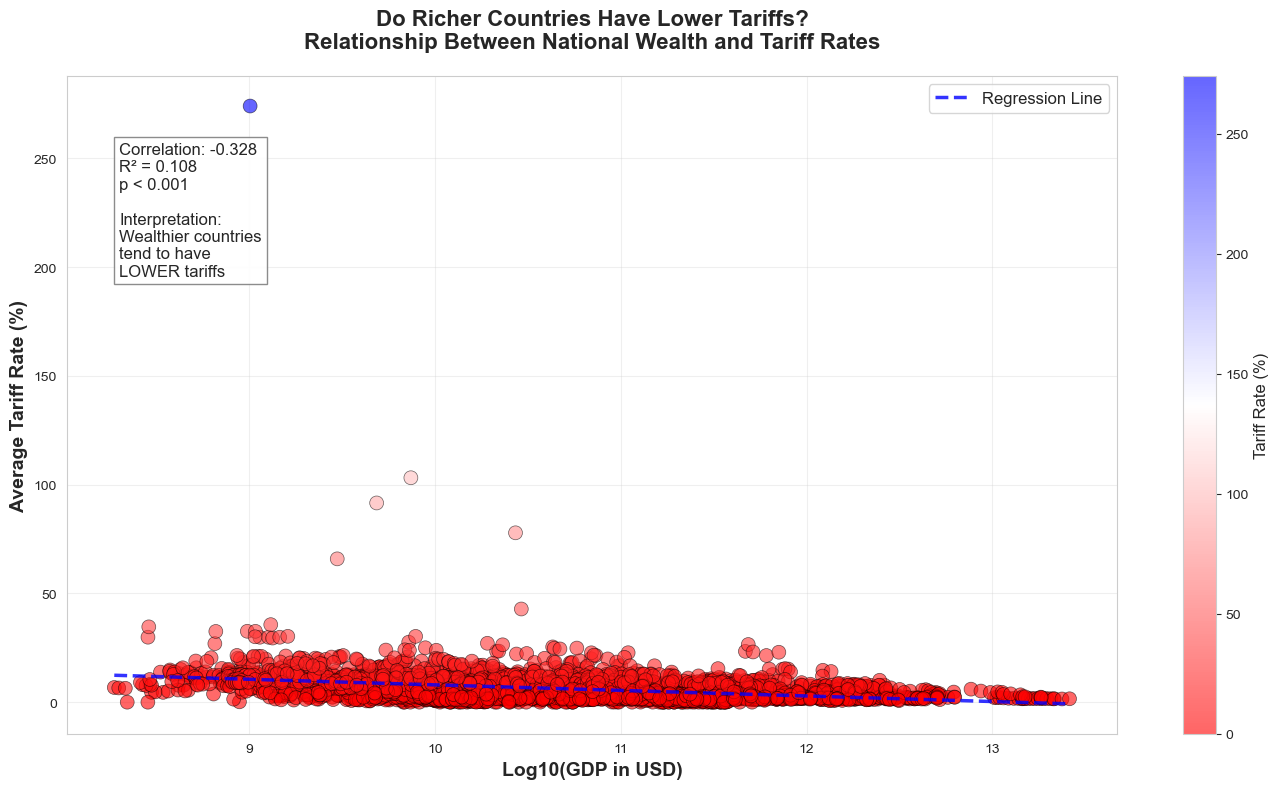

In [18]:
fig, ax = plt.subplots(figsize=(14, 8))
scatter = ax.scatter(
    merged["GDP_Log"],
    merged["Tariff_Rate"],
    c=merged["Tariff_Rate"],
    cmap="bwr_r",
    s=100,
    alpha=0.6,
    edgecolors="black",
    linewidth=0.5,
)

# Add regression line
X_line = np.linspace(merged["GDP_Log"].min(), merged["GDP_Log"].max(), 100)
y_pred = model.predict(X_line.reshape(-1, 1))
ax.plot(X_line, y_pred, "b--", linewidth=2.5, label="Regression Line", alpha=0.8)

ax.set_xlabel("Log10(GDP in USD)", fontsize=14, fontweight="bold")
ax.set_ylabel("Average Tariff Rate (%)", fontsize=14, fontweight="bold")
ax.set_title(
    "Do Richer Countries Have Lower Tariffs?\nRelationship Between National Wealth and Tariff Rates",
    fontsize=16,
    fontweight="bold",
    pad=20,
)

# Add statistics box
textstr = f"Correlation: {corr_log_gdp:.3f}\nR² = {r2:.3f}\np < 0.001\n\nInterpretation:\nWealthier countries\ntend to have\nLOWER tariffs"
props = dict(
    boxstyle="square", facecolor="white", edgecolor="grey", alpha=0.9, linewidth=1
)
ax.text(
    0.05,
    0.9,  # y position
    textstr,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=props,
)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Tariff Rate (%)", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("fig_gdp_tariff_scatter.png", dpi=300, bbox_inches="tight")
plt.show()

The scatter plot reveals a clear negative relationship between national wealth and average tariff rates: as countries become richer, they tend to apply lower tariffs. The downward-sloping regression line reinforces this relationship, showing that higher levels of economic wealth are systematically associated with lower trade protection.

At the same time, the dispersion of points highlights substantial heterogeneity across countries. While wealthier economies cluster tightly around low tariff levels - often below 5% - poorer countries exhibit a much wider range of tariff rates, including several extreme values above 20% and even 100%. This asymmetry suggests that high tariffs are primarily a feature of lower-income countries, whereas low tariffs are common across the income spectrum but nearly universal among richer economies.

## Hypothesis testing

The regression analysis demonstrates that the wealth-tariff relationship is both statistically significant and economically meaningful. However, regression tells us about the overall relationship across all countries. To directly test our core hypothesis (that the poorest and richest countries occupy fundamentally different trade policy regimes) we need a more targeted statistical test comparing these specific groups.

We'll use a two-sample t-test to determine if the difference between poorest and richest countries is statistically significant or could have occurred by chance.

Our hypotheses:

</br>

$$
\begin{aligned}
\text{H}_0 \; (\text{Null hypothesis}) &: \quad \mu_{\text{poorest}} = \mu_{\text{richest}}
\;\;\Rightarrow\;\; \text{no difference in mean tariffs} \\[8pt]
\text{H}_1 \; (\text{Alternative hypothesis}) &: \quad \mu_{\text{poorest}} > \mu_{\text{richest}}
\;\;\Rightarrow\;\; \text{poorest countries have higher tariffs}
\end{aligned}
$$

</br>

Decision rule:

</br>

$$
\begin{aligned}
\text{If } p\text{-value} < 0.05
&\;\Rightarrow\; \text{reject } \text{H}_0
\;\;(\text{statistically significant higher tariffs in poorest}) \\[8pt]
\text{If } p\text{-value} \ge 0.05
&\;\Rightarrow\; \text{fail to reject } \text{H}_0
\;\;(\text{insufficient evidence of higher tariffs in poorest})
\end{aligned}
$$

</br>

What "statistically significant" means in this case: if we found this large a difference in a world where wealth and tariffs were truly unrelated, it would happen less than 5% of the time by random chance alone. In other words, we can be 95% confident the relationship is real, not a statistical lucky occurence.

In [19]:
heading("HYPOTHESIS TESTING")

print("RESEARCH QUESTION:")
print("Do the poorest countries have significantly higher tariffs than the richest?")
print("\nHYPOTHESES:")
print("H0 (Null): Poorest and richest countries have equal average tariffs")
print("H1 (Alternative): Poorest countries have higher average tariffs")

# Two-sample t-test
t_stat, t_pvalue = stats.ttest_ind(poorest, richest, alternative="greater")

print(f"\nTWO-SAMPLE T-TEST RESULTS:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {t_pvalue:.6f}")
print(f"Sample sizes: Poorest n={len(poorest)}, Richest n={len(richest)}")

print("\n" + "-" * 60)
print("DECISION:")
if t_pvalue < 0.05:
    print("REJECT the null hypothesis (p < 0.05)")


HYPOTHESIS TESTING

RESEARCH QUESTION:
Do the poorest countries have significantly higher tariffs than the richest?

HYPOTHESES:
H0 (Null): Poorest and richest countries have equal average tariffs
H1 (Alternative): Poorest countries have higher average tariffs

TWO-SAMPLE T-TEST RESULTS:
T-statistic: 15.4803
P-value: 0.000000
Sample sizes: Poorest n=803, Richest n=803

------------------------------------------------------------
DECISION:
REJECT the null hypothesis (p < 0.05)


The results indicate a t-statistic of 15.4803 and a p-value effectively equal to zero, with equal sample sizes of 803 observations in each group. Given this extraordinarily low p-value, we decisively reject the null hypothesis at the conventional 5% significance level.
The magnitude of the t-statistic (15.48) is large, indicating that the difference between the poorest and richest countries is not just statistically detectable but profoundly substantial. With 803 observations per group spanning 23 years of data (2000-2022), this represents one of the most statistically powerful tests in our analysis, providing overwhelming evidence for the wealth-tariff relationship.

The evidence strongly supports the conclusion that poorer countries face higher tariffs on average, whereas wealthier countries tend to maintain lower tariff levels.

## Trade openness analysis

GDP is not the only factor that might influence tariff policy. Countries that are heavily integrated into the global economy (high trade-to-GDP ratios) might face different incentives than more isolated economies.

We'll divide countries into high-trade and low-trade groups (using median trade-to-GDP as the cutoff) and test whether they have significantly different tariff rates.

Key question: is the wealth-tariff relationship we've found actually just a wealth-trade relationship? Or is trade openness an independent factor?

In [20]:
heading("TRADE OPENNESS ANALYSIS")

df_test = merged.dropna(subset=["Trade_Pct_GDP", "Tariff_Rate"])
median_trade = df_test["Trade_Pct_GDP"].median()
high_trade = df_test[df_test["Trade_Pct_GDP"] >= median_trade]["Tariff_Rate"]
low_trade = df_test[df_test["Trade_Pct_GDP"] < median_trade]["Tariff_Rate"]

t_stat_trade, p_value_trade = stats.ttest_ind(high_trade, low_trade)

print("COMPARING HIGH-TRADE vs LOW-TRADE COUNTRIES:")
print(
    f"\nHigh-trade countries (n={len(high_trade)}): Mean tariff = {high_trade.mean():.2f}%"
)
print(
    f"Low-trade countries (n={len(low_trade)}): Mean tariff = {low_trade.mean():.2f}%"
)
print(f"Difference: {abs(high_trade.mean() - low_trade.mean()):.2f} percentage points")
print(f"\nT-statistic: {t_stat_trade:.3f}")
print(f"P-value: {p_value_trade:.4f}")

if p_value_trade < 0.05:
    print("\nResult: STATISTICALLY SIGNIFICANT (p < 0.05)")
else:
    print("\nResult: NO significant difference (p >= 0.05)")


TRADE OPENNESS ANALYSIS

COMPARING HIGH-TRADE vs LOW-TRADE COUNTRIES:

High-trade countries (n=1460): Mean tariff = 4.83%
Low-trade countries (n=1460): Mean tariff = 6.98%
Difference: 2.15 percentage points

T-statistic: -7.655
P-value: 0.0000

Result: STATISTICALLY SIGNIFICANT (p < 0.05)


The t-test yields a statistically significant result ($t$ = -7.655, $p$ < 0.0001), providing strong evidence that countries with high trade openness have systematically different tariff policies than those with low trade openness. Specifically, high-trade countries maintain an average tariff of 4.83%, while low-trade countries impose an average tariff of 6.98% - a difference of 2.15 percentage points.

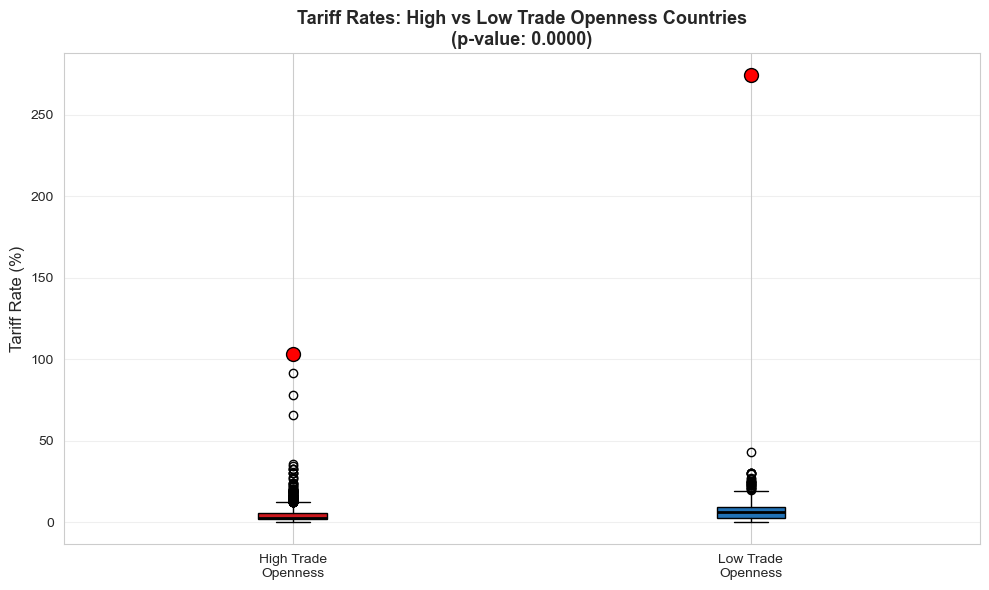

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
bp = ax.boxplot(
    [high_trade, low_trade],
    tick_labels=["High Trade\nOpenness", "Low Trade\nOpenness"],
    patch_artist=True,
)

bp["boxes"][0].set_facecolor("#cb181d")
bp["boxes"][1].set_facecolor("#2171b5")

x_positions = [1, 2]

for x, data in zip(x_positions, [high_trade, low_trade]):
    extreme = data[data > 100]
    ax.scatter(
        [x] * len(extreme),
        extreme,
        color="red",
        edgecolor="black",
        s=100,
        zorder=5,
        label="Tariff > 100%" if x == 1 else "",
    )

for median in bp["medians"]:
    median.set(color="black", linewidth=2)

ax.set_ylabel("Tariff Rate (%)", fontsize=12)
ax.set_title(
    f"Tariff Rates: High vs Low Trade Openness Countries\n(p-value: {p_value_trade:.4f})",
    fontsize=13,
    fontweight="bold",
)
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("fig_trade_openness_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

The boxplot further supports the previous result by showing lower median tariffs and a tighter distribution among high-trade countries, while low-trade countries exhibit higher central values and greater dispersion. Although a small number of extreme outliers exist, particularly among high-trade countries, the overall pattern indicates that higher trade openness is associated with lower and more stable tariff rates. This finding is consistent with the view that more open economies rely less on tariff barriers as part of their trade policy framework.

Without extremes outliers for better visualizations

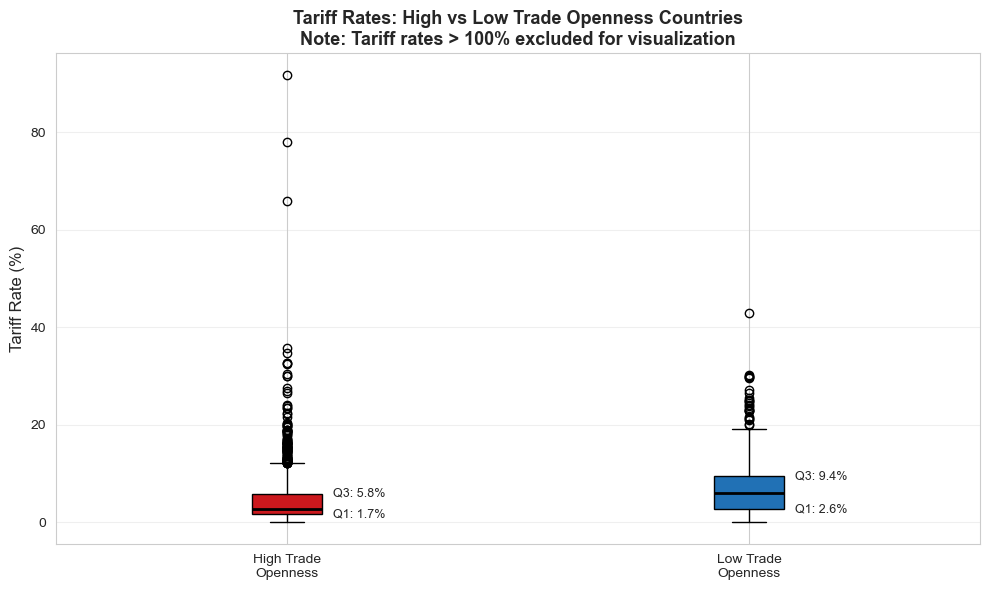

In [22]:
high_trade_viz = high_trade[high_trade <= 100]
low_trade_viz = low_trade[low_trade <= 100]

q1_high, q3_high = np.percentile(high_trade_viz, [25, 75])
q1_low, q3_low = np.percentile(low_trade_viz, [25, 75])

fig, ax = plt.subplots(figsize=(10, 6))
bp = ax.boxplot(
    [high_trade_viz, low_trade_viz],
    tick_labels=["High Trade\nOpenness", "Low Trade\nOpenness"],
    patch_artist=True,
)

bp["boxes"][0].set_facecolor("#cb181d")
bp["boxes"][1].set_facecolor("#2171b5")

for median in bp["medians"]:
    median.set(color="black", linewidth=2)

ax.text(1.1, q1_high, f"Q1: {q1_high:.1f}%", va="center", fontsize=9)
ax.text(1.1, q3_high, f"Q3: {q3_high:.1f}%", va="center", fontsize=9)

ax.text(2.1, q1_low, f"Q1: {q1_low:.1f}%", va="center", fontsize=9)
ax.text(2.1, q3_low, f"Q3: {q3_low:.1f}%", va="center", fontsize=9)

ax.set_ylabel("Tariff Rate (%)", fontsize=12)
ax.set_title(
    f"Tariff Rates: High vs Low Trade Openness Countries\nNote: Tariff rates > 100% excluded for visualization",
    fontsize=13,
    fontweight="bold",
)
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("fig_trade_openness_boxplot_no_extreme.png", dpi=300, bbox_inches="tight")
plt.show()

# Final considerations

We've examined our research question from multiple angles - descriptive statistics, visualizations, correlation, regression and hypothesis testing. Now it's time to  step back and synthesize what we've learned.

The analysis clearly indicates that richer countries maintain lower tariffs than poorer countries, and the evidence strongly supports this conclusion. On average, countries in the poorest quartile impose tariffs of 10.40%, while those in the richest quartile have average tariffs of only 3.65%, a difference of 6.74 percentage points - or 184.5% higher for poorer nations.

This wealth-tariff gap is not only substantial but also statistically robust. The negative correlation of -0.3284 confirms an inverse relationship between income and tariffs, with an $R^2$ of 0.1079, meaning that income explains about 11% of the variation in tariffs across countries. The p-value is far below conventional significance thresholds, indicating that this relationship is extremely unlikely to be due to chance.

Importantly, this pattern has persisted consistently over time. Between 2000 and 2022, the wealth - tariff gap remained stable, suggesting that it reflects a structural feature of the global economy rather than a temporary fluctuation.

The implications are significant: tariff policies are closely tied to economic development, with countries tending to lower tariffs as they grow wealthier. This reinforces that global trade inequality is multifaceted, extending beyond mere tariff levels, and highlights the need for development strategies that recognize and address the persistent link between wealth and trade policy.